In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## prefix / infix exploration

In [ ]:
# Python Program to convert prefix to Infix
def prefixToInfix(prefix):
    stack = []
     
    # read prefix in reverse order
    prefix = prefix.split()
    i = len(prefix) - 1
    while i >= 0:
        if not isOperator(prefix[i]):
             
            # symbol is operand
            stack.append(prefix[i])
            i -= 1
        else:
           
            # symbol is operator
            str = "(" + stack.pop() + prefix[i] + stack.pop() + ")"
            stack.append(str)
            i -= 1
     
    return stack.pop()
 
def isOperator(c):
    if c == "*" or c == "+" or c == "-" or c == "/" or c == "^" or c == "(" or c == ")":
        return True
    else:
        return False
 
# Driver code
if __name__=="__main__":
    str = "* - A / B C - / A K L"
    # str = "*-A/BC-/AKL"
    print(prefixToInfix(str))

((A-(B/C))*((A/K)-L))


In [ ]:
"x=" + prefixToInfix("* + 23 61 29")

'x=((23+61)*29)'

In [ ]:
"* + 23 61 29".split()

['*', '+', '23', '61', '29']

## Dependency graph exploration

#### exploration with SpaCy

In [ ]:
!pip install transformers

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_trf


✘ No compatible model found for 'en_core_web_trf' (spaCy v2.2.4).



In [ ]:
import spacy
import numpy as np
nlp = spacy.load("en_core_web_sm")
doc = nlp('john eat NUM apples and jesus has NUM apples')
adj_m = np.zeros((len(doc), len(doc)))
childs = {}
for j,token in enumerate(doc):
    if token.text in childs.keys():
        childs[token.text].append(j)
    else:
        childs[token.text] = [j]
for j,token in enumerate(doc):
    childs[str(token.head)].append(j)
for j,token in enumerate(doc):
  add = childs[token.text]
  for i in range(len(add)):
    adj_m[j, add[i]] =1

In [ ]:
childs

{'NUM': [2, 7],
 'and': [4],
 'apples': [3, 8, 2, 4, 5, 7],
 'eat': [1, 0, 1, 3, 6],
 'has': [6, 8],
 'jesus': [5],
 'john': [0]}

In [ ]:
adj_m

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 1., 1., 1., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 1., 1., 1., 0., 1., 1.]])

In [ ]:
batch = ["sofia president of the school student organization held a meeting to talk about the food being served at the school cafeteria . the first order of business is to discuss whether the students like the food being served at the school . if NUM students said that they like the food and NUM students said they did n't how many students participated in the discussion ?", 'Will had NUM pieces of clothing to wash . He put NUM of them in one load , but decided to split the rest into NUM equal loads . How many pieces of clothing could go in each of the small loads ?', 'Keith found NUM seashells , Jessica found NUM seashells , and Tim found NUM seashells on the beach . When they cleaned them , they discovered that NUM were cracked . How many seashells did they find together ?', 'Edward made NUM dollars mowing lawns over the summer . If he spent NUM dollars buying new mower blades , how many NUM dollar games could he buy with the money he had left ?', "there are NUM squirrels in a tree with NUM nuts . what 's the difference of the number of squirrels and nuts over there ?", 'There were NUM book shelves . Each book shelf had NUM books . How many books were on the shelves ?', 'Alyssa has NUM books . Nancy has NUM times more books than Alyssa . How many books does Nancy have ?', 'isabel had NUM ds games . if she gave NUM to her friend how many would she have left ?']


In [ ]:
batch_0 = ['john had to complete 14 pages more than paul of reading homework and 5 more pages of biology homework . how many pages of math and reading homework did she have to complete ?']

In [ ]:
from transformers.models.roberta.tokenization_roberta import VOCAB_FILES_NAMES
import torch.nn as nn
import torch
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
import pdb

class BertEncoder(nn.Module):
	def __init__(self, bert_model = 'bert-base-uncased',device = 'cpu ', freeze_bert = False):
		super(BertEncoder, self).__init__()
		self.bert_layer = BertModel.from_pretrained(bert_model)
		self.bert_tokenizer = BertTokenizer.from_pretrained(bert_model)
		self.device = device
		
		if freeze_bert:
			for p in self.bert_layer.parameters():
				p.requires_grad = False
		
	def bertify_input(self, sentences):
		'''
		Preprocess the input sentences using bert tokenizer and converts them to a torch tensor containing token ids

		'''
		#Tokenize the input sentences for feeding into BERT
		# pdb.set_trace()
		all_tokens  = [['[CLS]'] + self.bert_tokenizer.tokenize(sentence) + ['[SEP]'] for sentence in sentences]

		index_retrieve = []
		for sent in all_tokens:
			cur_ls = []
			for j in range(1, len(sent)):
				if sent[j][0] == '#':
					continue
				else:
					cur_ls.append(j)
			index_retrieve.append(cur_ls)
		
		#Pad all the sentences to a maximum length
		input_lengths = [len(tokens) for tokens in all_tokens]
		max_length    = max(input_lengths)
		padded_tokens = [tokens + ['[PAD]' for _ in range(max_length - len(tokens))] for tokens in all_tokens]

		#Convert tokens to token ids
		token_ids = torch.tensor([self.bert_tokenizer.convert_tokens_to_ids(tokens) for tokens in padded_tokens]).to(self.device)

		#Obtain attention masks
		pad_token = self.bert_tokenizer.convert_tokens_to_ids('[PAD]')
		attn_masks = (token_ids != pad_token).long()

		return token_ids, attn_masks, input_lengths, index_retrieve

	def forward(self, sentences):
		'''
		Feed the batch of sentences to a BERT encoder to obtain contextualized representations of each token
		'''
		#Preprocess sentences
		token_ids, attn_masks, input_lengths, index_retrieve = self.bertify_input(sentences)

		#Feed through bert
		cont_reps, _ = self.bert_layer(token_ids, attention_mask = attn_masks)

		return cont_reps, input_lengths, token_ids, index_retrieve

class RobertaEncoder(nn.Module):
	def __init__(self, roberta_model = 'roberta-base', device = 'cpu', freeze_roberta = False):
		super(RobertaEncoder, self).__init__()
		self.roberta_layer = RobertaModel.from_pretrained(roberta_model)
		self.roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model)
		self.device = device
		
		if freeze_roberta:
			for p in self.roberta_layer.parameters():
				p.requires_grad = False
		
	def robertify_input(self, sentences):
		'''
		Preprocess the input sentences using roberta tokenizer and converts them to a torch tensor containing token ids

		'''
		# Tokenize the input sentences for feeding into RoBERTa
		all_tokens  = [['<s>'] + self.roberta_tokenizer.tokenize(sentence) + ['</s>'] for sentence in sentences]
		
		index_retrieve = []
		all_words = []
		for sent in all_tokens:
			cur_ls = [1]
			word = ['<', sent[1]]
			for j in range(2, len(sent)):
				if sent[j][0] == '\u0120':
					cur_ls.append(j)
					word.append(sent[j][1:])
				else:
					word.append(sent[j][:])
			index_retrieve.append(cur_ls)
			all_words.append(word)
   				
		# Pad all the sentences to a maximum length
		input_lengths = [len(tokens) for tokens in all_tokens]
		max_length    = max(input_lengths)
		padded_tokens = [tokens + ['<pad>' for _ in range(max_length - len(tokens))] for tokens in all_tokens]
		print(padded_tokens)

		# Convert tokens to token ids
		token_ids = torch.tensor([self.roberta_tokenizer.convert_tokens_to_ids(tokens) for tokens in padded_tokens]).to(self.device)
		pad_word = [word for word in all_words]

		# Obtain attention masks
		pad_token = self.roberta_tokenizer.convert_tokens_to_ids('<pad>')
		attn_masks = (token_ids != pad_token).long()

		return token_ids, attn_masks, input_lengths, index_retrieve, pad_word

	def forward(self, sentences):
		'''
		Feed the batch of sentences to a RoBERTa encoder to obtain contextualized representations of each token
		'''
		# Preprocess sentences
		token_ids, attn_masks, input_lengths, index_retrieve, word = self.robertify_input(sentences)

		# Feed through RoBERTa
		cont_reps, _ = self.roberta_layer(token_ids, attention_mask = attn_masks)

		return cont_reps, input_lengths, token_ids, index_retrieve, word

In [ ]:
embed = RobertaEncoder()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
t,att,inp_l,id, w = embed.robertify_input(batch_0)

[['<s>', 'john', 'Ġhad', 'Ġto', 'Ġcomplete', 'Ġ14', 'Ġpages', 'Ġmore', 'Ġthan', 'Ġp', 'aul', '</s>']]


In [ ]:
w[0]

In [ ]:
att[0].numpy().astype('bool')

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
test = ' '.join(w[0])

In [ ]:
import spacy
import numpy as np
nlp = spacy.load("en_core_web_sm")
doc = nlp(test)
# doc = nlp('john eat NUM apples and jesus has NUM apples')
adj_m = np.zeros((71, 71))
childs = {}
for j in id[0]:
    token = doc[j]
    childs[token.text] = [j]
for j in id[0]:
    token = doc[j]
    if str(token.head) in childs.keys():
        childs[str(token.head)].append(j)
for j in id[0]:
  token = doc[j]
  add = childs[token.text]
  for i in range(len(add)):
    # print(add[0], add[i])
    adj_m[add[0], add[i]] =1

In [ ]:
test.split(" ")[:]

['<',
 'r',
 'achel',
 'had',
 'to',
 'complete',
 '14',
 'pages',
 'of',
 'math',
 'homework',
 '20',
 'pages',
 'of',
 'reading',
 'homework',
 'and',
 '5',
 'more',
 'pages',
 'of',
 'biology',
 'homework',
 '.',
 'how',
 'many',
 'pages',
 'of',
 'math',
 'and',
 'reading',
 'homework',
 'did',
 'she',
 'have',
 'to',
 'complete',
 '?',
 '</s>']

In [ ]:
childs

{'.': [23],
 '14': [6],
 '20': [11],
 '5': [17, 18],
 '?': [37],
 'and': [29],
 'biology': [21],
 'complete': [36, 4, 7, 12, 35],
 'did': [32],
 'had': [3, 3, 5, 23],
 'have': [34, 26, 32, 33, 34, 36, 37],
 'homework': [31, 9, 21],
 'how': [24],
 'many': [25, 24],
 'math': [28, 29, 30],
 'more': [18],
 'of': [27, 10, 14, 22, 28],
 'pages': [26, 6, 8, 11, 13, 16, 17, 19, 20, 25, 27],
 'r': [1],
 'reading': [30, 15, 31],
 'she': [33],
 'to': [35]}

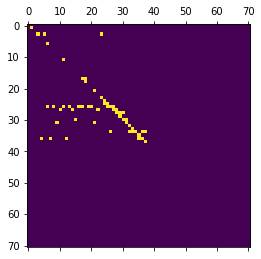

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# a 2D array with linearly increasing values on the diagonal
a = np.diag(range(15))

plt.matshow(adj_m[:,:])

plt.show()

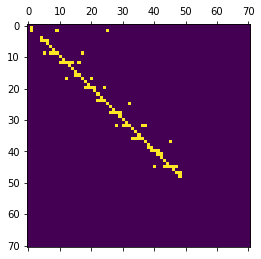

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# a 2D array with linearly increasing values on the diagonal
a = np.diag(range(15))

plt.matshow(adj_m_1[:,:])

plt.show()

In [ ]:
import spacy
from spacy import displacy
from pathlib import Path

nlp = spacy.load("en_core_web_sm")
# doc = nlp(u"allan brought 2 balloons more than jake")
# Since this is an interactive Jupyter environment, we can use displacy.render here
# svg= displacy.render(doc, jupyter=True)
# # file_name = '-'.join([w.text for w in doc if not w.is_punct]) + ".png"
# output_path = Path("/content/" + 'dep_parse')
# output_path.open("w+", encoding="utf-8").write(svg)
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)

sentence_nlp = nlp("john had to complete 14 pages more than jerry")
# svg = displacy.render(doc, style="dep")
displacy.render(sentence_nlp , style="dep", jupyter=True)
# output_path = Path("/content/dependency_plot.svg") # you can keep there only "dependency_plot.svg" if you want to save it in the same folder where you run the script 
# output_path.open("w", encoding="utf-8").write(svg)

In [ ]:
import spacy
import numpy as np
nlp = spacy.load("en_core_web_sm")
doc = nlp("allan brought 2 balloons more than jake")
adj_m = np.zeros((len(doc), len(doc)))
childs = {}
for j,token in enumerate(doc):
    childs[token.text] = [j]
for j,token in enumerate(doc):
    childs[str(token.head)].append(j)
for j,token in enumerate(doc):
  add = childs[token.text]
  for i in range(len(add)):
    adj_m[add[0], add[i]] =1

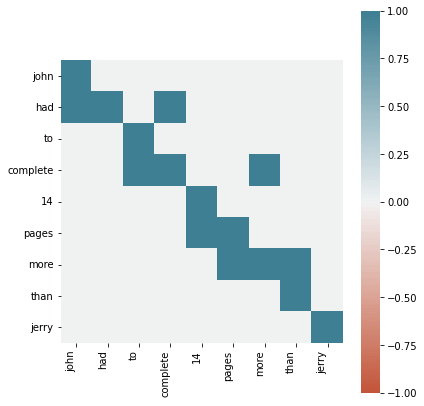

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,6))
# corr = data.corr()
ax = sns.heatmap(
    adj_m[1:10,1:10], 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=False
)
ax.set_xticklabels(
    labels=ss[1:],
    rotation=90,
    horizontalalignment='right',

)
ax.set_yticklabels(
    ss[1:],
    rotation=0,
    horizontalalignment='right',

)
plt.tight_layout()
plt.savefig("dependency_matrix.png")

In [ ]:
!pip install cairosvg

     |████████████████████████████████| 45 kB 1.9 MB/s 
     |████████████████████████████████| 88 kB 4.3 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=595def667175a6eea52c07f7402e5d2a97a06b9b569cb7ee8d7d7340ebbb4515
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [ ]:
from cairosvg import svg2png

svg_code = """
   <svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" id="eef332269b8344b99dc71e7432aa5cfb-0" class="displacy" width="6875" height="662.0" direction="ltr" style="max-width: none; height: 662.0px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">
<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="50">&lt;</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">X</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="225">r</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">PROPN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="400">achel</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="400">PROPN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="575">had</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="575">AUX</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="750">to</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="750">PART</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="925">complete</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="925">VERB</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="1100">14</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="1100">NUM</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="1275">pages</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="1275">NOUN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="1450">of</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="1450">ADP</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="1625">math</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="1625">NOUN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="1800">homework</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="1800">PROPN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="1975">20</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="1975">NUM</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="2150">pages</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="2150">NOUN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="2325">of</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="2325">ADP</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="2500">reading</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="2500">VERB</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="2675">homework</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="2675">NOUN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="2850">and</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="2850">CCONJ</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="3025">5</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="3025">NUM</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="3200">more</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="3200">ADJ</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="3375">pages</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="3375">NOUN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="3550">of</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="3550">ADP</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="3725">biology</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="3725">NOUN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="3900">homework .</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="3900">NOUN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="4075">how</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="4075">ADV</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="4250">many</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="4250">ADJ</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="4425">pages</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="4425">NOUN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="4600">of</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="4600">ADP</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="4775">math</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="4775">NOUN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="4950">and</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="4950">CCONJ</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="5125">reading</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="5125">PROPN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="5300">homework</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="5300">PROPN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="5475">did</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="5475">AUX</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="5650">she</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="5650">PRON</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="5825">have</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="5825">AUX</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="6000">to</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="6000">PART</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="6175">complete ?</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="6175">VERB</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="6350">&lt;</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="6350">X</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="6525">/s</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="6525">PROPN</tspan>
</text>

<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">
    <tspan class="displacy-word" fill="currentColor" x="6700">&gt;</tspan>
    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="6700">X</tspan>
</text>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-0" stroke-width="2px" d="M70,527.0 C70,264.5 560.0,264.5 560.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-0" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">dep</textPath>
    </text>
    <path class="displacy-arrowhead" d="M70,529.0 L62,517.0 78,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-1" stroke-width="2px" d="M245,527.0 C245,439.5 375.0,439.5 375.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-1" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">compound</textPath>
    </text>
    <path class="displacy-arrowhead" d="M245,529.0 L237,517.0 253,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-2" stroke-width="2px" d="M420,527.0 C420,439.5 550.0,439.5 550.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-2" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">nsubj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M420,529.0 L412,517.0 428,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-3" stroke-width="2px" d="M770,527.0 C770,439.5 900.0,439.5 900.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-3" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">aux</textPath>
    </text>
    <path class="displacy-arrowhead" d="M770,529.0 L762,517.0 778,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-4" stroke-width="2px" d="M595,527.0 C595,352.0 905.0,352.0 905.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-4" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">xcomp</textPath>
    </text>
    <path class="displacy-arrowhead" d="M905.0,529.0 L913.0,517.0 897.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-5" stroke-width="2px" d="M1120,527.0 C1120,439.5 1250.0,439.5 1250.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-5" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">nummod</textPath>
    </text>
    <path class="displacy-arrowhead" d="M1120,529.0 L1112,517.0 1128,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-6" stroke-width="2px" d="M945,527.0 C945,352.0 1255.0,352.0 1255.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-6" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">dobj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M1255.0,529.0 L1263.0,517.0 1247.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-7" stroke-width="2px" d="M1295,527.0 C1295,439.5 1425.0,439.5 1425.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-7" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">prep</textPath>
    </text>
    <path class="displacy-arrowhead" d="M1425.0,529.0 L1433.0,517.0 1417.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-8" stroke-width="2px" d="M1645,527.0 C1645,439.5 1775.0,439.5 1775.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-8" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">compound</textPath>
    </text>
    <path class="displacy-arrowhead" d="M1645,529.0 L1637,517.0 1653,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-9" stroke-width="2px" d="M1470,527.0 C1470,352.0 1780.0,352.0 1780.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-9" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">pobj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M1780.0,529.0 L1788.0,517.0 1772.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-10" stroke-width="2px" d="M1995,527.0 C1995,439.5 2125.0,439.5 2125.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-10" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">nummod</textPath>
    </text>
    <path class="displacy-arrowhead" d="M1995,529.0 L1987,517.0 2003,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-11" stroke-width="2px" d="M945,527.0 C945,89.5 2145.0,89.5 2145.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-11" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">dobj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M2145.0,529.0 L2153.0,517.0 2137.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-12" stroke-width="2px" d="M2170,527.0 C2170,439.5 2300.0,439.5 2300.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-12" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">prep</textPath>
    </text>
    <path class="displacy-arrowhead" d="M2300.0,529.0 L2308.0,517.0 2292.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-13" stroke-width="2px" d="M2345,527.0 C2345,439.5 2475.0,439.5 2475.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-13" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">pcomp</textPath>
    </text>
    <path class="displacy-arrowhead" d="M2475.0,529.0 L2483.0,517.0 2467.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-14" stroke-width="2px" d="M2520,527.0 C2520,439.5 2650.0,439.5 2650.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-14" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">dobj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M2650.0,529.0 L2658.0,517.0 2642.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-15" stroke-width="2px" d="M2170,527.0 C2170,177.0 2840.0,177.0 2840.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-15" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">cc</textPath>
    </text>
    <path class="displacy-arrowhead" d="M2840.0,529.0 L2848.0,517.0 2832.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-16" stroke-width="2px" d="M3045,527.0 C3045,352.0 3355.0,352.0 3355.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-16" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">nummod</textPath>
    </text>
    <path class="displacy-arrowhead" d="M3045,529.0 L3037,517.0 3053,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-17" stroke-width="2px" d="M3045,527.0 C3045,439.5 3175.0,439.5 3175.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-17" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">amod</textPath>
    </text>
    <path class="displacy-arrowhead" d="M3175.0,529.0 L3183.0,517.0 3167.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-18" stroke-width="2px" d="M2170,527.0 C2170,89.5 3370.0,89.5 3370.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-18" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">conj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M3370.0,529.0 L3378.0,517.0 3362.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-19" stroke-width="2px" d="M3395,527.0 C3395,439.5 3525.0,439.5 3525.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-19" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">prep</textPath>
    </text>
    <path class="displacy-arrowhead" d="M3525.0,529.0 L3533.0,517.0 3517.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-20" stroke-width="2px" d="M3745,527.0 C3745,439.5 3875.0,439.5 3875.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-20" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">compound</textPath>
    </text>
    <path class="displacy-arrowhead" d="M3745,529.0 L3737,517.0 3753,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-21" stroke-width="2px" d="M3570,527.0 C3570,352.0 3880.0,352.0 3880.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-21" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">pobj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M3880.0,529.0 L3888.0,517.0 3872.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-22" stroke-width="2px" d="M4095,527.0 C4095,439.5 4225.0,439.5 4225.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-22" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">advmod</textPath>
    </text>
    <path class="displacy-arrowhead" d="M4095,529.0 L4087,517.0 4103,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-23" stroke-width="2px" d="M4270,527.0 C4270,439.5 4400.0,439.5 4400.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-23" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">amod</textPath>
    </text>
    <path class="displacy-arrowhead" d="M4270,529.0 L4262,517.0 4278,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-24" stroke-width="2px" d="M4445,527.0 C4445,2.0 5825.0,2.0 5825.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-24" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">dobj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M4445,529.0 L4437,517.0 4453,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-25" stroke-width="2px" d="M4445,527.0 C4445,439.5 4575.0,439.5 4575.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-25" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">prep</textPath>
    </text>
    <path class="displacy-arrowhead" d="M4575.0,529.0 L4583.0,517.0 4567.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-26" stroke-width="2px" d="M4620,527.0 C4620,439.5 4750.0,439.5 4750.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-26" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">pobj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M4750.0,529.0 L4758.0,517.0 4742.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-27" stroke-width="2px" d="M4795,527.0 C4795,439.5 4925.0,439.5 4925.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-27" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">cc</textPath>
    </text>
    <path class="displacy-arrowhead" d="M4925.0,529.0 L4933.0,517.0 4917.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-28" stroke-width="2px" d="M4795,527.0 C4795,352.0 5105.0,352.0 5105.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-28" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">conj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M5105.0,529.0 L5113.0,517.0 5097.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-29" stroke-width="2px" d="M5145,527.0 C5145,439.5 5275.0,439.5 5275.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-29" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">dobj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M5275.0,529.0 L5283.0,517.0 5267.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-30" stroke-width="2px" d="M5495,527.0 C5495,352.0 5805.0,352.0 5805.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-30" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">aux</textPath>
    </text>
    <path class="displacy-arrowhead" d="M5495,529.0 L5487,517.0 5503,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-31" stroke-width="2px" d="M5670,527.0 C5670,439.5 5800.0,439.5 5800.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-31" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">nsubj</textPath>
    </text>
    <path class="displacy-arrowhead" d="M5670,529.0 L5662,517.0 5678,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-32" stroke-width="2px" d="M6020,527.0 C6020,439.5 6150.0,439.5 6150.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-32" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">aux</textPath>
    </text>
    <path class="displacy-arrowhead" d="M6020,529.0 L6012,517.0 6028,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-33" stroke-width="2px" d="M5845,527.0 C5845,352.0 6155.0,352.0 6155.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-33" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">xcomp</textPath>
    </text>
    <path class="displacy-arrowhead" d="M6155.0,529.0 L6163.0,517.0 6147.0,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-34" stroke-width="2px" d="M6370,527.0 C6370,439.5 6500.0,439.5 6500.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-34" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">dep</textPath>
    </text>
    <path class="displacy-arrowhead" d="M6370,529.0 L6362,517.0 6378,517.0" fill="currentColor"/>
</g>

<g class="displacy-arrow">
    <path class="displacy-arc" id="arrow-eef332269b8344b99dc71e7432aa5cfb-0-35" stroke-width="2px" d="M6545,527.0 C6545,439.5 6675.0,439.5 6675.0,527.0" fill="none" stroke="currentColor"/>
    <text dy="1.25em" style="font-size: 0.8em; letter-spacing: 1px">
        <textPath xlink:href="#arrow-eef332269b8344b99dc71e7432aa5cfb-0-35" class="displacy-label" startOffset="50%" side="left" fill="currentColor" text-anchor="middle">punct</textPath>
    </text>
    <path class="displacy-arrowhead" d="M6675.0,529.0 L6683.0,517.0 6667.0,517.0" fill="currentColor"/>
</g>
</svg>
"""

svg2png(bytestring=svg_code,write_to='output.png')

#### exploration with stanford

In [ ]:
!wget https://nlp.stanford.edu/software/stanford-corenlp-4.2.2.zip
!wget https://nlp.stanford.edu/software/stanford-corenlp-4.2.2-models-english.jar
!unzip /content/stanford-corenlp-4.2.2.zip

--2022-03-31 16:41:50--  https://nlp.stanford.edu/software/stanford-corenlp-4.2.2.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-4.2.2.zip [following]
--2022-03-31 16:41:50--  https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-4.2.2.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 504278711 (481M) [application/zip]
Saving to: ‘stanford-corenlp-4.2.2.zip’

stanford-corenlp-4. 100%[===================>] 480.92M  5.07MB/s    in 91s     

2022-03-31 16:43:21 (5.27 MB/s) - ‘stanford-corenlp-4.2.2.zip’ saved [504278711/504278711]

--2022-03-31 16:43:21--  https://nlp.st

In [ ]:
# 

from nltk.parse.stanford import StanfordDependencyParser

# Path to CoreNLP jar unzipped
jar_path = '/content/stanford-corenlp-4.2.2/stanford-corenlp-4.2.2.jar'

# Path to CoreNLP model jar
models_jar_path = '/content/stanford-corenlp-4.2.2-models-english.jar'

sentence = 'allan brought 2 balloons more than jake'

# Initialize StanfordDependency Parser from the path
parser = StanfordDependencyParser(path_to_jar = jar_path, path_to_models_jar = models_jar_path)

# Parse the sentence
result = parser.raw_parse(sentence)
dependency = result.__next__()


print ("{:<15} | {:<10} | {:<10} | {:<15} | {:<10}".format('Head', 'Head POS','Relation','Dependent', 'Dependent POS'))
print ("-" * 75)
  
# Use dependency.triples() to extract the dependency triples in the form
# ((head word, head POS), relation, (dependent word, dependent POS))  
for dep in list(dependency.triples()):
  print ("{:<15} | {:<10} | {:<10} | {:<15} | {:<10}"
         .format(str(dep[0][0]),str(dep[0][1]), str(dep[1]), str(dep[2][0]),str(dep[2][1])))

Head            | Head POS   | Relation   | Dependent       | Dependent POS
---------------------------------------------------------------------------
brought         | VBD        | nsubj      | allan           | NN        
brought         | VBD        | obl        | jake            | NN        
jake            | NN         | advmod     | more            | RBR       
more            | RBR        | obl:npmod  | balloons        | NNS       
balloons        | NNS        | nummod     | 2               | CD        
jake            | NN         | case       | than            | IN        


In [ ]:
!pip install stanfordcorenlp

In [ ]:
from stanfordcorenlp import StanfordCoreNLP

# PAD_token = 0
# NLP__ = spacy.load("en_core_web_sm")
STDP__ = StanfordCoreNLP('/content/drive/MyDrive/ift6289/hms/stanford-corenlp-4.4.0', lang='en')

In [ ]:
dd = STDP__.dependency_parse(test)

In [ ]:
test.split(" ")

In [ ]:
dd

[('ROOT', 0, 3),
 ('punct', 3, 1),
 ('nsubj', 3, 2),
 ('compound', 6, 4),
 ('compound', 6, 5),
 ('dep', 10, 6),
 ('case', 6, 7),
 ('punct', 10, 8),
 ('nsubj', 10, 9),
 ('ccomp', 3, 10),
 ('compound', 13, 11),
 ('compound', 13, 12),
 ('nsubj', 18, 13),
 ('case', 13, 14),
 ('punct', 13, 15),
 ('cc', 17, 16),
 ('conj', 13, 17),
 ('ccomp', 10, 18),
 ('compound', 21, 19),
 ('compound', 21, 20),
 ('xcomp', 18, 21),
 ('case', 21, 22),
 ('case', 25, 23),
 ('det', 25, 24),
 ('dep', 21, 25),
 ('punct', 3, 26),
 ('ROOT', 0, 7),
 ('advmod', 3, 1),
 ('nsubj', 3, 2),
 ('advcl', 7, 3),
 ('obj', 3, 4),
 ('punct', 7, 5),
 ('nsubj', 7, 6),
 ('mark', 11, 8),
 ('nsubj:pass', 11, 9),
 ('aux:pass', 11, 10),
 ('ccomp', 7, 11),
 ('punct', 7, 12),
 ('ROOT', 0, 8),
 ('advmod', 2, 1),
 ('amod', 3, 2),
 ('obj', 8, 3),
 ('dep', 3, 4),
 ('case', 4, 5),
 ('aux', 8, 6),
 ('nsubj', 8, 7),
 ('advmod', 8, 9),
 ('punct', 8, 10),
 ('ROOT', 0, 1)]

In [ ]:
adj_m = np.zeros((71, 71))
childs = {}
for k, word in enumerate(dd):
    typ, j, i = word
    if typ=='ROOT':
      add = k
    i= add+i-1
    j= add+j-1
    if i>=0 and j>=0:
      # adj_m[i, i] =1
      adj_m[j, i] =1

In [ ]:
adj_m_1 = np.zeros((71, 71))
childs = {}
for k, word in enumerate(dd):
    typ, j, i = word
    if typ=='ROOT':
      add = k
    i= add+i-1
    j= add+j-1
    if i>=0 and j>=0:
      if i in id[0]:
        adj_m_1[i, i] =1
        adj_m_1[j, i] =1

In [ ]:
import numpy as np

In [ ]:
adj_m = np.zeros((len(dependency.nodes), len(dependency.nodes)))
childs = {}
for i in range(len(dependency.nodes)):
  if i==0:
    pass
  else:
    head = dependency.nodes[i]['head']
    adj_m[i, i] =1
    adj_m[head, i] =1
# for j,token in enumerate(doc):
#     childs[token.text] = [j]
# for j,token in enumerate(doc):
#     childs[str(token.head)].append(j)
# for j,token in enumerate(doc):
#   add = childs[token.text]
# for i in range(len(add)):
    # adj_m[add[0], add[i]] =1
adj_m = adj_m[1:,1:]

In [ ]:
adj_m.dtype

dtype('float64')

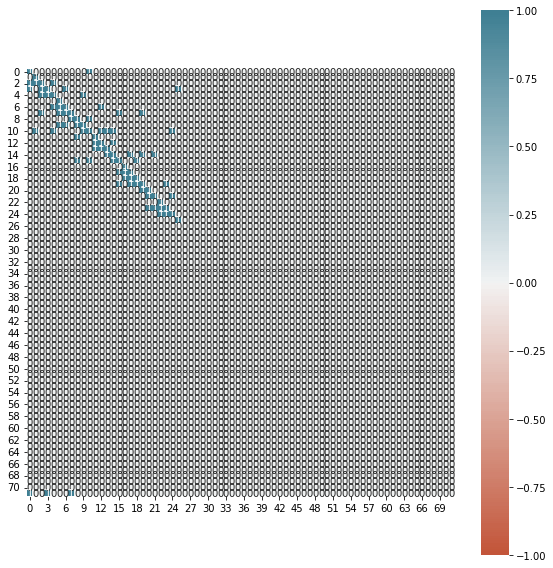

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
# corr = data.corr()
ax = sns.heatmap(
    adj_m, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
# ax.set_xticklabels(
#     # ,
#     rotation=90,
#     horizontalalignment='right',

# )
# ax.set_yticklabels(
#     # ,
#     rotation=0,
#     horizontalalignment='right',

# )
plt.tight_layout()
plt.savefig("dependency_matrix.png")

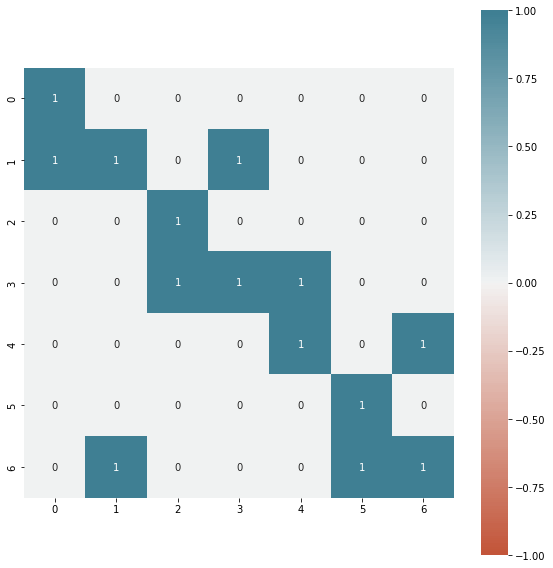

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
# corr = data.corr()
ax = sns.heatmap(
    adj_m, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
# ax.set_xticklabels(
#     # ,
#     rotation=90,
#     horizontalalignment='right',

# )
# ax.set_yticklabels(
#     # ,
#     rotation=0,
#     horizontalalignment='right',

# )
plt.tight_layout()
plt.savefig("dependency_matrix.png")

In [ ]:
!pip install graphviz
from graphviz import Source
dot_def = dependency.to_dot()
'''
The below lines require graphviz executables to be installed to your system. If that does not work, print the dot_def object and paste the output on http://graphs.grevian.org/graph/
'''
source = Source(dot_def, filename="dependency_graph", format="png")
source.view()

'dependency_graph.png'